Create a 30minute dataset for comparison with modeled data. We use the uncleaned 5 minute data, upsample only covariance variables, and repeat the cleaning processes that were applied to the 5 minute data in `clean_turbulence_dataset.ipynb`

In [50]:
import pandas as pd
from sublimpy import tidy
import numpy as np
import matplotlib.pyplot as plt
from sublimpy import turbulence

# Open data

## Open SOS Measurement Dataset

In [51]:
start_date = '20221130'
end_date = '20230509'
# open files
tidy_df_5Min_fn = f'tidy_df_{start_date}_{end_date}_noplanar_fit.parquet'
tidy_df_5Min = pd.read_parquet(tidy_df_5Min_fn)
# convert time column to datetime
tidy_df_5Min['time'] = pd.to_datetime(tidy_df_5Min['time'])
# limit data to our dates of interest, based on continuous snow cover at Kettle Ponds
tidy_df_5Min = tidy_df_5Min.set_index('time').sort_index().loc[start_date:end_date].reset_index()

OUTPUT_FILENAME = f'tidy_df_30min_{start_date}_{end_date}_noplanar_fit_clean.parquet'

# Identify covariance variables

In [26]:
covariance_variable_sets = [
    ('w_h2o__3m_c',      'w_3m_c',   'h2o_3m_c'),
    ('w_h2o__5m_c',      'w_5m_c',   'h2o_5m_c'),
    ('w_h2o__10m_c',     'w_10m_c',  'h2o_10m_c'),
    ('w_h2o__15m_c',     'w_15m_c',  'h2o_15m_c'),
    ('w_h2o__20m_c',     'w_20m_c',  'h2o_20m_c'),
    ('w_h2o__3m_d',      'w_3m_d',   'h2o_3m_d'),
    ('w_h2o__10m_d',     'w_10m_d',  'h2o_10m_d'),
    ('w_h2o__3m_ue',     'w_3m_ue',  'h2o_3m_ue'),
    ('w_h2o__10m_ue',    'w_10m_ue', 'h2o_10m_ue'),
    ('w_h2o__3m_uw',     'w_3m_uw',  'h2o_3m_uw'),
    ('w_h2o__10m_uw',    'w_10m_uw', 'h2o_10m_uw'),

    ('w_tc__3m_c',       'w_3m_c',   'tc_3m_c'),
    ('w_tc__5m_c',       'w_5m_c',   'tc_5m_c'),
    ('w_tc__10m_c',      'w_10m_c',  'tc_10m_c'),
    ('w_tc__15m_c',      'w_15m_c',  'tc_15m_c'),
    ('w_tc__20m_c',      'w_20m_c',  'tc_20m_c'),
    ('w_tc__3m_d',       'w_3m_d',   'tc_3m_d'),
    ('w_tc__10m_d',      'w_10m_d',  'tc_10m_d'),
    ('w_tc__3m_ue',      'w_3m_ue',  'tc_3m_ue'),
    ('w_tc__10m_ue',     'w_10m_ue', 'tc_10m_ue'),
    ('w_tc__3m_uw',      'w_3m_uw',  'tc_3m_uw'),
    ('w_tc__10m_uw',     'w_10m_uw', 'tc_10m_uw'),

    ('u_w__3m_c',        'u_3m_c',       'w_3m_c'),
    ('u_w__5m_c',        'u_5m_c',       'w_5m_c'),
    ('u_w__10m_c',       'u_10m_c',      'w_10m_c'),
    ('u_w__15m_c',       'u_15m_c',      'w_15m_c'),
    ('u_w__20m_c',       'u_20m_c',      'w_20m_c'),
    ('u_w__3m_d',        'u_3m_d',       'w_3m_d'),
    ('u_w__10m_d',       'u_10m_d',      'w_10m_d'),
    ('u_w__3m_ue',       'u_3m_ue',      'w_3m_ue'),
    ('u_w__10m_ue',      'u_10m_ue',     'w_10m_ue'),
    ('u_w__3m_uw',       'u_3m_uw',      'w_3m_uw'),
    ('u_w__10m_uw',      'u_10m_uw',     'w_10m_uw'),

    ('v_w__3m_c',        'v_3m_c',       'w_3m_c'),
    ('v_w__5m_c',        'v_5m_c',       'w_5m_c'),
    ('v_w__10m_c',       'v_10m_c',      'w_10m_c'),
    ('v_w__15m_c',       'v_15m_c',      'w_15m_c'),
    ('v_w__20m_c',       'v_20m_c',      'w_20m_c'),
    ('v_w__3m_d',        'v_3m_d',       'w_3m_d'),
    ('v_w__10m_d',       'v_10m_d',      'w_10m_d'),
    ('v_w__3m_ue',       'v_3m_ue',      'w_3m_ue'),
    ('v_w__10m_ue',      'v_10m_ue',     'w_10m_ue'),
    ('v_w__3m_uw',       'v_3m_uw',      'w_3m_uw'),
    ('v_w__10m_uw',      'v_10m_uw',     'w_10m_uw'),
]

counts_variables = [
    'counts_3m_c_1',
    'counts_5m_c_1',
    'counts_10m_c_1',
    'counts_15m_c_1',
    'counts_20m_c_1',

    'counts_3m_d_1',
    'counts_10m_d_1',

    'counts_3m_ue_1',
    'counts_10m_ue_1',

    'counts_3m_uw_1',
    'counts_10m_uw_1',
]

In [27]:
all_relevant_covariance_variables = list(np.array(covariance_variable_sets).flatten()) + counts_variables

# Create 30min dataset but remove all the covariance variables and lh-flux-related counts variables

In [28]:
# Properly calculate 30min covariances from 5min covariances
tidy_df_30Min = tidy_df_5Min.set_index('time').groupby(
    [pd.Grouper(freq='30Min'), 'tower', 'height', 'measurement', 'variable']
).mean().reset_index()

tidy_df_30Min = tidy_df_30Min[
    ~ tidy_df_30Min.variable.isin(all_relevant_covariance_variables)
]

# Isolate relevant covariance variables in 5 minute dataset

In [29]:
tidy_df_5Min_only_cov_variables = tidy_df_5Min[tidy_df_5Min.variable.isin(
    list(np.array(covariance_variable_sets).flatten()) + counts_variables

)]

# Properly calculate covariances, but each new calculated variable in its own dataframe

In [30]:
upsampled_covariance_variable_dfs = []
for variable_set in covariance_variable_sets:
    cov, component1, component2 = variable_set
    pivoted_df = tidy_df_5Min_only_cov_variables[tidy_df_5Min_only_cov_variables.variable.isin(
        variable_set
    )].pivot(index='time', columns='variable', values='value')
    # We need to do this
    agg_df = pd.DataFrame({
        cov: pivoted_df.groupby(pd.Grouper(freq='30Min')).apply(
            lambda row: 
                (1/6)*(row[cov] + row[component1]*row[component2]).sum()
                - (
                    (1/6)*row[component1].sum()
                    * (1/6)*row[component2].sum()
                )
        )
    })
    upsampled_covariance_variable_dfs.append(agg_df)

<Axes: xlabel='time'>

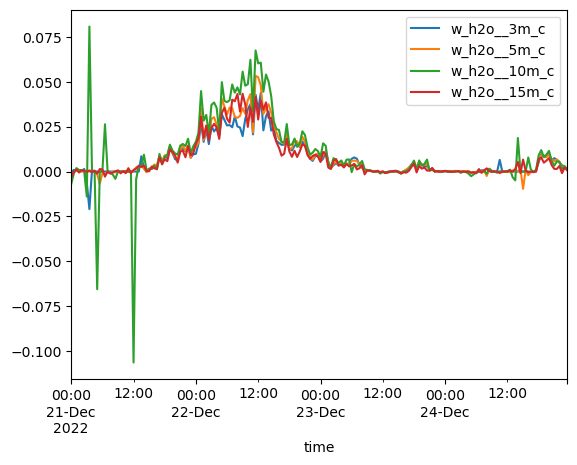

In [31]:
fig, axes = plt.subplots()
upsampled_covariance_variable_dfs[0].loc['20221221': '20221224'].plot(ax=axes)
upsampled_covariance_variable_dfs[1].loc['20221221': '20221224'].plot(ax=axes)
upsampled_covariance_variable_dfs[2].loc['20221221': '20221224'].plot(ax=axes)
upsampled_covariance_variable_dfs[3].loc['20221221': '20221224'].plot(ax=axes)

# Add new 30min covariance calculations to tidy_df_30_min

In [32]:
for df in upsampled_covariance_variable_dfs:
    assert len(df.columns) == 1
    variable = df.columns[0]
    height = int(variable.split('__')[1].split('m_')[0])
    tower = variable.split('_')[-1]
    measurement = variable.split('__')[0] + '_'
    print(variable, height, tower, variable)
    # tidy_df_30Min
    tidy_df_30Min = tidy.tidy_df_add_variable(
        tidy_df_30Min,
        df[variable].values,
        variable,
        measurement,
        height,
        tower
    )

w_h2o__3m_c 3 c w_h2o__3m_c
w_h2o__5m_c 5 c w_h2o__5m_c
w_h2o__10m_c 10 c w_h2o__10m_c
w_h2o__15m_c 15 c w_h2o__15m_c
w_h2o__20m_c 20 c w_h2o__20m_c
w_h2o__3m_d 3 d w_h2o__3m_d
w_h2o__10m_d 10 d w_h2o__10m_d
w_h2o__3m_ue 3 ue w_h2o__3m_ue
w_h2o__10m_ue 10 ue w_h2o__10m_ue
w_h2o__3m_uw 3 uw w_h2o__3m_uw
w_h2o__10m_uw 10 uw w_h2o__10m_uw
w_tc__3m_c 3 c w_tc__3m_c
w_tc__5m_c 5 c w_tc__5m_c
w_tc__10m_c 10 c w_tc__10m_c
w_tc__15m_c 15 c w_tc__15m_c
w_tc__20m_c 20 c w_tc__20m_c
w_tc__3m_d 3 d w_tc__3m_d
w_tc__10m_d 10 d w_tc__10m_d
w_tc__3m_ue 3 ue w_tc__3m_ue
w_tc__10m_ue 10 ue w_tc__10m_ue
w_tc__3m_uw 3 uw w_tc__3m_uw
w_tc__10m_uw 10 uw w_tc__10m_uw
u_w__3m_c 3 c u_w__3m_c
u_w__5m_c 5 c u_w__5m_c
u_w__10m_c 10 c u_w__10m_c
u_w__15m_c 15 c u_w__15m_c
u_w__20m_c 20 c u_w__20m_c
u_w__3m_d 3 d u_w__3m_d
u_w__10m_d 10 d u_w__10m_d
u_w__3m_ue 3 ue u_w__3m_ue
u_w__10m_ue 10 ue u_w__10m_ue
u_w__3m_uw 3 uw u_w__3m_uw
u_w__10m_uw 10 uw u_w__10m_uw
v_w__3m_c 3 c v_w__3m_c
v_w__5m_c 5 c v_w__5m_c
v_w_

# Add new 30min lh-flux flag-count variables to tidy_df_30_min (sums of 5minute count values)

In [33]:
for var in counts_variables:
        new_count_var_tidy_df = tidy_df_5Min_only_cov_variables[
                tidy_df_5Min_only_cov_variables.variable == var
        ].set_index('time').groupby(
                [pd.Grouper(freq='30Min'), 'tower', 'height', 'measurement', 'variable']
        ).sum().reset_index()
        tidy_df_30Min = pd.concat([
                tidy_df_30Min,
                new_count_var_tidy_df
        ])

# Repeating the first cleaning step applied to 5min data (remove data points with > 10% of data flagged)

In [34]:
ec_lhflux_and_counts_variables = [
    # ('w_h2o__2m_c', 'counts_2m_c_1'), 
    ('w_h2o__3m_c', 'counts_3m_c_1'), 
    ('w_h2o__5m_c', 'counts_5m_c_1'), 
    ('w_h2o__10m_c', 'counts_10m_c_1'), 
    ('w_h2o__15m_c', 'counts_15m_c_1'), 
    ('w_h2o__20m_c', 'counts_20m_c_1'), 


    # ('w_h2o__1m_d', 'counts_1m_d_1'), 
    ('w_h2o__3m_d', 'counts_3m_d_1'), 
    ('w_h2o__10m_d', 'counts_10m_d_1'), 
      
    # ('w_h2o__1m_ue', 'counts_1m_ue_1'), 
    ('w_h2o__3m_ue', 'counts_3m_ue_1'), 
    ('w_h2o__10m_ue', 'counts_10m_ue_1'), 


    # ('w_h2o__1m_uw',  'counts_1m_uw_1'), 
    ('w_h2o__3m_uw', 'counts_3m_uw_1'), 
    ('w_h2o__10m_uw', 'counts_10m_uw_1'), 
]
ec_lhflux_variables = list(zip(*ec_lhflux_and_counts_variables))[0]

In [35]:
all_lhflux_measurements = tidy_df_30Min[tidy_df_30Min.variable.isin(ec_lhflux_variables)].value
# lower_threshold = all_lhflux_measurements.mean() - 5*all_lhflux_measurements.std()
# upper_threshold = all_lhflux_measurements.mean() + 5*all_lhflux_measurements.std()
# don't actually do any outlier filtering like this anymore
lower_threshold = all_lhflux_measurements.min() - 1
upper_threshold = all_lhflux_measurements.max() + 1
lower_threshold, upper_threshold

(-1.578131333792446, 1.7120356908985521)

In [36]:
flux_var

'w_h2o__10m_uw'

In [37]:
GOOD_DATA_FRACTION = 0.9
dataframes = []

for flux_var, counts_var in ec_lhflux_and_counts_variables:
        flux_values = tidy_df_30Min.query(f"variable == '{flux_var}'").value.values
        new_values = turbulence.clean_eddy_covariance(
            flux_values,
            tidy_df_30Min.query(f"variable == '{counts_var}'").value.values,
            lower_threshold,
            upper_threshold,
            fraction_good_data_reqd = GOOD_DATA_FRACTION,
            counts_per_datapoint = 6000*6
        )
        dataframes.append(
            pd.DataFrame.from_dict({
                flux_var: new_values,
                'good_data_fraction': np.full(len(new_values), GOOD_DATA_FRACTION)
            })
        )

        # remove old variable and replace with new values
        tidy_df_30Min = tidy_df_30Min[tidy_df_30Min.variable != flux_var]
        tidy_df_30Min = tidy.tidy_df_add_variable(
            tidy_df_30Min,
            new_values,
            flux_var,
            measurement = 'w_h2o_',
            height = int(flux_var.split('__')[1].split('m_')[0]),
            tower = flux_var.split('_')[-1]
        )

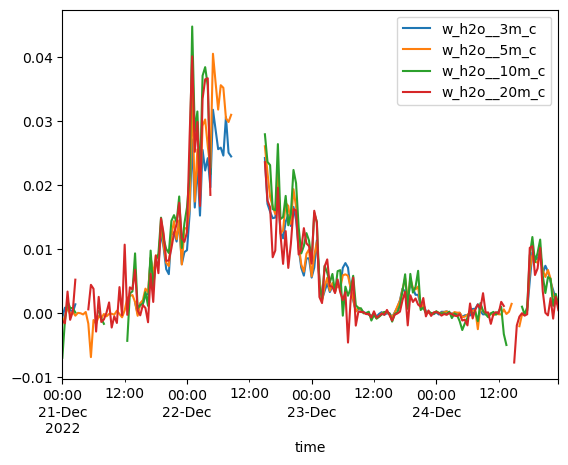

In [38]:
tidy_df_30Min.query("variable == 'w_h2o__3m_c'").set_index('time').loc["20221221": "20221224"]['value'].plot(label = 'w_h2o__3m_c')
tidy_df_30Min.query("variable == 'w_h2o__5m_c'").set_index('time').loc["20221221": "20221224"]['value'].plot(label = 'w_h2o__5m_c')
tidy_df_30Min.query("variable == 'w_h2o__10m_c'").set_index('time').loc["20221221": "20221224"]['value'].plot(label = 'w_h2o__10m_c')
tidy_df_30Min.query("variable == 'w_h2o__20m_c'").set_index('time').loc["20221221": "20221224"]['value'].plot(label = 'w_h2o__20m_c')
plt.legend()

# Add in u_w_rot variables and u* variables

In [45]:
from sublimpy import variables

In [48]:
tidy_df_30Min = tidy.tidy_df_add_variable(
    tidy_df_30Min,
    (
        tidy_df_30Min.query("variable == 'u_w__3m_c'")['value'].values**2 
        + tidy_df_30Min.query("variable == 'v_w__3m_c'")['value'].values**2
    ),
    'u_w_rot__3m_c',
    'u_w_rot__',
    3,
    'c'
)

tidy_df_30Min = tidy.tidy_df_add_variable(
    tidy_df_30Min,
    (
        tidy_df_30Min.query("variable == 'u_w__10m_c'")['value'].values**2 
        + tidy_df_30Min.query("variable == 'v_w__10m_c'")['value'].values**2
    ),
    'u_w_rot__10m_c',
    'u_w_rot__',
    10,
    'c'
)

tidy_df_30Min = tidy.tidy_df_add_variable(
    tidy_df_30Min,
    (
        tidy_df_30Min.query("variable == 'u_w__20m_c'")['value'].values**2 
        + tidy_df_30Min.query("variable == 'v_w__20m_c'")['value'].values**2
    ),
    'u_w_rot__20m_c',
    'u_w_rot__',
    20,
    'c'
)


# Save dataset to disk

In [39]:
tidy_df_30Min.to_parquet(
    OUTPUT_FILENAME
)

# DEPRECATED/OLD ANALYSIS:

 Do "proper" conversions for 5min covariances to 30min covariances, compare with simple averaging of covariances

In [40]:
w = tidy_df_5Min.query("variable == 'w_3m_c'")['value']
tc = tidy_df_5Min.query("variable == 'tc_3m_c'")['value']
w_tc__ = tidy_df_5Min.query("variable == 'w_tc__3m_c'")['value']

testdf = tidy_df_5Min[
    tidy_df_5Min.variable.isin(['w_3m_c', 'tc_3m_c', 'w_tc__3m_c'])
].pivot(index='time', columns='variable', values='value')
testdf.head()

w_tc__30min_proper = testdf.groupby(pd.Grouper(freq='30Min')).apply(
    lambda row: 
        (1/6)*(row['w_tc__3m_c'] + row['w_3m_c']*row['tc_3m_c']).sum()
        - (
            (1/6)*row['w_3m_c'].sum()
            * (1/6)*row['tc_3m_c'].sum()
        )
)
w_tc__30min_wrong = testdf.groupby(pd.Grouper(freq='30Min')).mean()['w_tc__3m_c']

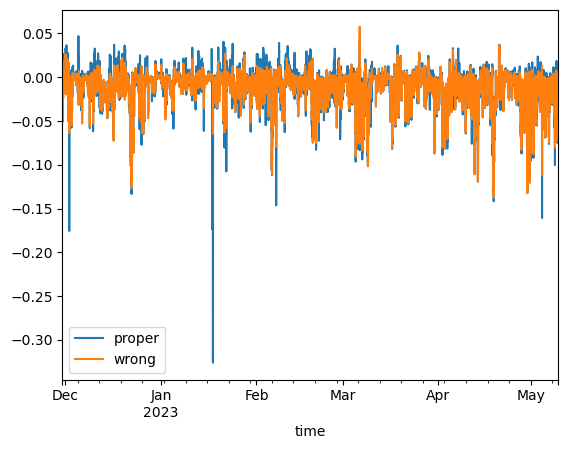

In [41]:
import matplotlib.pyplot as plt
w_tc__30min_proper.plot(label='proper')
w_tc__30min_wrong.plot(label='wrong')
plt.legend()

In [42]:
w = tidy_df_5Min.query("variable == 'w_3m_c'")['value']
tc = tidy_df_5Min.query("variable == 'h2o_3m_c'")['value']
w_tc__ = tidy_df_5Min.query("variable == 'w_h2o__3m_c'")['value']

testdf = tidy_df_5Min[
    tidy_df_5Min.variable.isin(['w_3m_c', 'h2o_3m_c', 'w_h2o__3m_c'])
].pivot(index='time', columns='variable', values='value')
testdf.head()

w_tc__30min_proper = testdf.groupby(pd.Grouper(freq='60Min')).apply(
    lambda row: 
        (1/12)*(row['w_h2o__3m_c'] + row['w_3m_c']*row['h2o_3m_c']).sum()
        - (
            (1/12)*row['w_3m_c'].sum()
            * (1/12)*row['h2o_3m_c'].sum()
        )
)
w_tc__30min_wrong = testdf.groupby(pd.Grouper(freq='30Min')).mean()['w_h2o__3m_c']

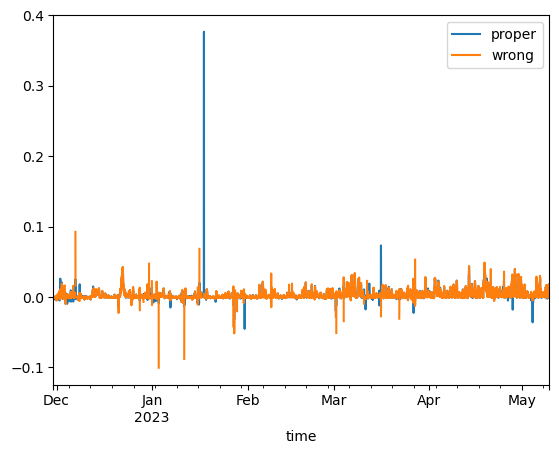

In [43]:
import matplotlib.pyplot as plt
w_tc__30min_proper.plot(label='proper')
w_tc__30min_wrong.plot(label='wrong')
plt.legend()

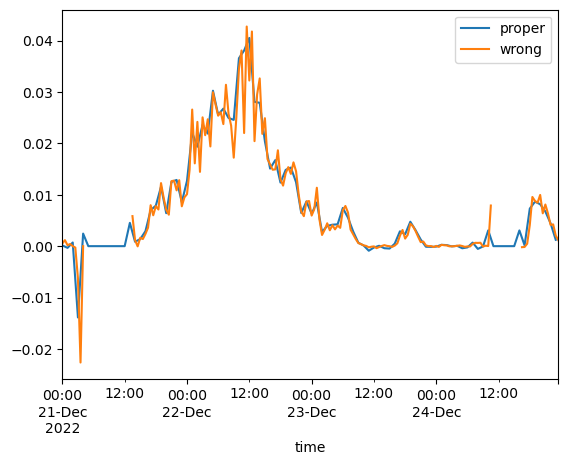

In [44]:
import matplotlib.pyplot as plt
w_tc__30min_proper.loc['20221221': '20221224'].plot(label='proper')
w_tc__30min_wrong.loc['20221221': '20221224'].plot(label='wrong')

plt.legend()